# FaIR Harmonized
### Erica Simon, 02/05/24
## Purpose: input harmonized historical and projected emissions trajectories into FaIR
- Emissions span 1750 to 2100
- For now, we will not run probabilistic projections


## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

## Create instance

In [2]:
f = FAIR()

## Define time horizon

In [3]:
f.define_time(1750, 2101, 1)

## Define scenarios

In [4]:
# use same scenario sames as those in emissions df
f.define_scenarios(['Below 2 C', 'Current Policies', 'Delayed transition',
                   'Fragmented World', 'Low demand', 'NDCs', 'Net Zero 2050'])

## Define configs

In [5]:
f.define_configs(['c1'])

## Define species & properties

In [6]:
species_configs = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/OMS-NetZero/FAIR/master/examples/data/species_configs_properties_calibration1.2.0.csv',
    known_hash = '4f9d25b21d632cf35953842a627db4b1612b465f68b2a824afff017a7390053b',
)

In [7]:
species, properties = read_properties(filename=species_configs)

# removed in examples from fair-calibrate repo, specifically because 'future projections aren't available'
species.remove("Halon-1202")
species.remove("NOx aviation")

f.define_species(species, properties)

## Create data arrays

In [8]:
# create empty emission and temp arrays
f.allocate()   

## Fill data arrays
- Emissions & forcings
- Climate configs
- Species configs
- Initial conditions

### Emissions

In [9]:
df_emis = pd.read_csv('~/outputs/GCAM_harm.csv')

In [10]:
# remove 'Emissions|' from variable name
for i in range(len(df_emis.Variable.values)): 
    df_emis.Variable.values[i] = df_emis.Variable.values[i][10:]

Fill `f.emissions` with values from `df_emis`

In [11]:
for scen in df_emis.scenario.unique():
    for var in df_emis.Variable.unique():
        if var in f.species:
            emis = df_emis.loc[df_emis['Variable'] == var].loc[df_emis['scenario'] == scen].values[0][5:].reshape(351,1)
            fill(f.emissions, emis, scenario=scen, specie=var)

We also need to check if any relevant species are not included in this dataset, excluding ones that are calculated from other values.

In [12]:
for element in f.species:
    if element not in df_emis['Variable'].values:
        if f.properties[element]['input_mode'] != 'calculated':
            print(element)

Solar
Volcanic


### solar & volcanic forcings

In [13]:
solar_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-add-hfc/main/data/solar_erf_timebounds.csv',
    known_hash = 'md5:98f6f4c5309d848fea89803683441acf',
)

In [14]:
volcanic_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-calibrate/main/data/forcing/volcanic_ERF_1750-2101_timebounds.csv',
    known_hash = 'md5:c0801f80f70195eb9567dbd70359219d',
)

In [15]:
df_solar = pd.read_csv(solar_obj, index_col="year")
df_volcanic = pd.read_csv(volcanic_obj, index_col="timebounds")

The solar forcing data spans from 1750-2101, but the volcanic has data until 2300, so we need to trim `volcanic_df` to only include 1750-2101.

In [16]:
s_yr_list = list(range(2102, 2301))
df_solar = df_solar.drop(s_yr_list)

In [21]:
for scen in f.scenarios:
    fill(f.forcing, df_volcanic, scenario=scen, specie='Volcanic')
    fill(f.forcing, df_solar, scenario=scen, specie='Solar')

### Climate configs

In [22]:
fill(f.climate_configs["ocean_heat_transfer"], [1.1, 1.6, 0.9], config='c1')
fill(f.climate_configs["ocean_heat_capacity"], [8, 14, 100], config='c1')
fill(f.climate_configs["deep_ocean_efficacy"], 1.1, config='c1')

### Species configs

In [23]:
# fill with default values
f.fill_species_configs()

### Initial conditions

In [24]:
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)   # f.temperature refers to temperature anomaly above PI (288 K)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

## Run

In [25]:
f.run()

Running 7 projections in parallel:   0%|          | 0/351 [00:00<?, ?timesteps/s]

## Analyze output

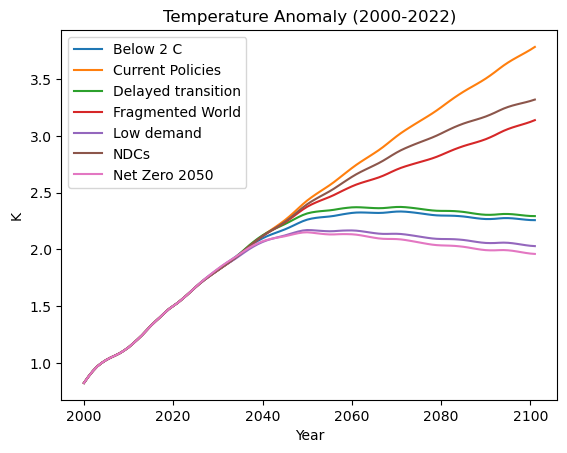

In [36]:
for scen in f.scenarios:
    plt.plot(f.timebounds[250:], f.temperature.loc[dict(scenario=scen, layer=0)][250:], label=scen)
plt.xlabel('Year')
plt.ylabel('K')
plt.title('Temperature Anomaly (2000-2022)')
plt.legend()
plt.show()